#                         Supervised Machine Learning: Classification

### Introduction
We will be using the Human Activity Recognition with Smartphones database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided:

Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
Triaxial Angular velocity from the gyroscope.
A 561-feature vector with time and frequency domain variables.
Its activity label.

In [1]:
# Import the necessary libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, sys

C:\Users\raman\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\raman\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\raman\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Read the file
filepath = 'F:\\Coursera\\IBM Machine Learning Professional Certificate\\Course 3_Supervised Learning_Classification\\Final Project\\Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath, sep=',')

In [3]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


### Data Exploration

In [4]:
data.shape

(10299, 562)

The data columns are all floats except for the activity label.

In [5]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [6]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [7]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [8]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [9]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

In [10]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
corr_array = np.array(corr_values)
corr_array[np.tril_indices_from(corr_values)] = np.nan

# recreate correlation pandas dataframe
corr_values = pd.DataFrame(corr_array,columns = corr_values.columns, index = corr_values.index)

# Stack the data and convert to a dataframe
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text yticklabel objects>)

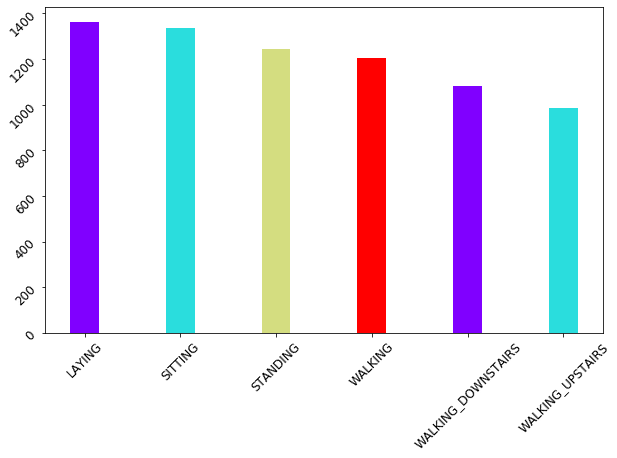

In [12]:
# Data Visualization
import matplotlib.cm as cm
count_of_each_activity = np.array(y_train.value_counts())
activities = sorted(y_train.unique())
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.figure(figsize=(10,6))
plt.bar(activities,count_of_each_activity,width=0.3,color=colors)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(rotation=45,fontsize=12)

([<matplotlib.patches.Wedge at 0x1e0bac5bf60>,
 [Text(0.9121289404751981, 0.6148339580306154, 'LAYING'),
  Text(-0.21504004519819878, 1.0787760559824995, 'SITTING'),
  Text(-1.0656462070182775, 0.27276026372541656, 'STANDING'),
  Text(-0.7531206776833063, -0.8017538555229015, 'WALKING'),
  Text(0.26369462766475305, -1.0679256263152164, 'WALKING_DOWNSTAIRS'),
  Text(1.0004049732078233, -0.457372812463809, 'WALKING_UPSTAIRS')],
 [Text(0.4975248766228353, 0.33536397710760835, '18.88'),
  Text(-0.11729457010810841, 0.5884233032631815, '18.50'),
  Text(-0.5812615674645149, 0.148778325668409, '17.26'),
  Text(-0.410793096918167, -0.4373202848306735, '16.72'),
  Text(0.14383343327168346, -0.5825048870810271, '15.00'),
  Text(0.5456754399315399, -0.249476079525714, '13.65')])

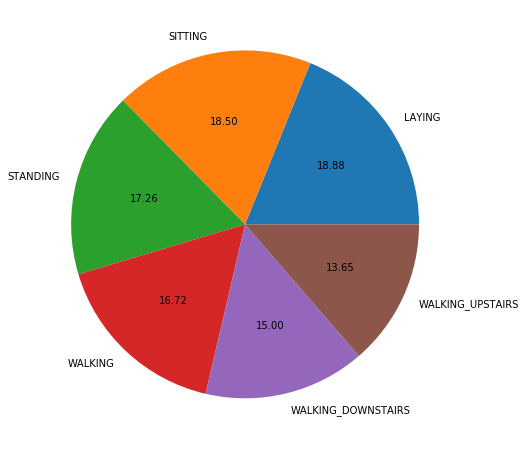

In [13]:
plt.figure(figsize=(16,8))
plt.pie(count_of_each_activity, labels = activities, autopct = '%0.2f')

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either 'LabelEncoder' needs to be used to convert the activity labels to integers.
Use 'LabelEncoder' to fit_transform the "Activity" column, and look at 5 random values.

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

8936    0
9617    1
2956    0
6765    4
6627    2
Name: Activity, dtype: int32

Calculate the correlations between the dependent variables. 
Create a histogram of the correlation values. 
Identify those that are most correlated (either positively or negatively).

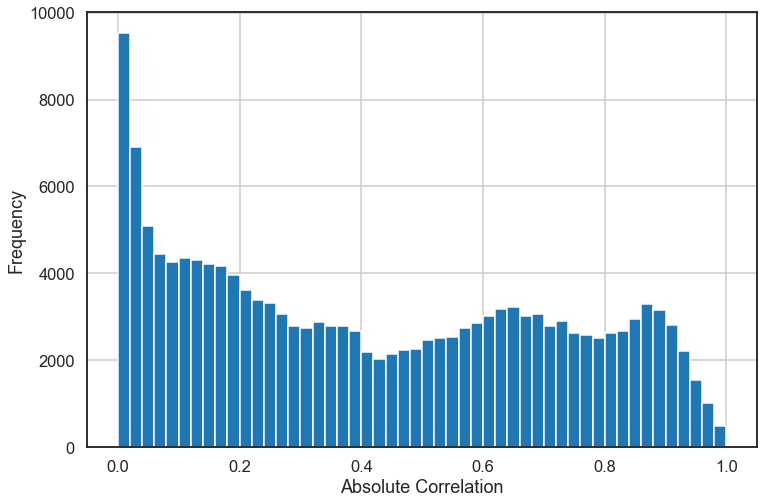

In [15]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [16]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


In [17]:
y_train.value_counts(normalize=True)

LAYING                0.188792
STANDING              0.185046
SITTING               0.172562
WALKING               0.167152
WALKING_UPSTAIRS      0.149951
WALKING_DOWNSTAIRS    0.136496
Name: Activity, dtype: float64

In [18]:
y_test.value_counts(normalize=True)

LAYING                0.188673
STANDING              0.185113
SITTING               0.172492
WALKING               0.167314
WALKING_UPSTAIRS      0.149838
WALKING_DOWNSTAIRS    0.136570
Name: Activity, dtype: float64

### Summary of training at least three different classifier models

In [19]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [20]:
y_pred = lr.predict(X_test)

In [21]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score=accuracy_score(y_test,y_pred)
recall_score=recall_score(y_test,y_pred,average='weighted')
f1_score=f1_score(y_test,y_pred,average='weighted')
print(y_pred)
print(cm)
print(accuracy_score)
print(recall_score)
print(f1_score)

['WALKING' 'WALKING_UPSTAIRS' 'WALKING' ... 'SITTING' 'SITTING'
 'WALKING_UPSTAIRS']
[[583   0   0   0   0   0]
 [  0 512  21   0   0   0]
 [  0  22 550   0   0   0]
 [  0   0   0 515   1   1]
 [  0   0   0   1 420   1]
 [  0   0   0   1   1 461]]
0.9841423948220065
0.9841423948220065
0.984142828415666


In [22]:
accuracy_scores = np.zeros(4)

In [23]:
from sklearn.metrics import accuracy_score
accuracy_scores[0] = accuracy_score(y_test, y_pred)*100
print('Logistic Regression accuracy: {}%'.format(accuracy_scores[0]))

Logistic Regression accuracy: 98.41423948220066%


In [24]:
# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier().fit(X_train, y_train)

In [25]:
prediction = clf.predict(X_test)

In [26]:
accuracy_scores[1] = accuracy_score(y_test, prediction)*100
print('K Nearest Neighbors Classifier accuracy: {}%'.format(accuracy_scores[1]))

K Nearest Neighbors Classifier accuracy: 96.44012944983818%


In [27]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score
cm = confusion_matrix(y_test, prediction)
accuracy_score=accuracy_score(y_test,prediction)
recall_score=recall_score(y_test,prediction,average='weighted')
f1_score=f1_score(y_test,prediction,average='weighted')
print(prediction)
print(cm)
print(accuracy_score)
print(recall_score)
print(f1_score)

['WALKING' 'WALKING_UPSTAIRS' 'WALKING' ... 'SITTING' 'SITTING'
 'WALKING_UPSTAIRS']
[[582   1   0   0   0   0]
 [  1 479  52   0   0   1]
 [  0  44 528   0   0   0]
 [  0   0   0 517   0   0]
 [  0   0   0   6 413   3]
 [  0   0   0   0   2 461]]
0.9644012944983819
0.9644012944983819
0.9643655770411813


In [28]:
# Support Vector Classifier
from sklearn.svm import SVC
svc = SVC().fit(X_train, y_train)

In [29]:
prediction = svc.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score
accuracy_scores[2] = accuracy_score(y_test, prediction)*100
print('Support Vector Classifier accuracy: {}%'.format(accuracy_scores[2]))

Support Vector Classifier accuracy: 97.47572815533981%


In [31]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score
cm = confusion_matrix(y_test, prediction)
accuracy_score=accuracy_score(y_test,prediction)
recall_score=recall_score(y_test,prediction,average='weighted')
f1_score=f1_score(y_test,prediction,average='weighted')
print(prediction)
print(cm)
print(accuracy_score)
print(recall_score)
print(f1_score)

['WALKING' 'WALKING_UPSTAIRS' 'WALKING' ... 'SITTING' 'SITTING'
 'WALKING_UPSTAIRS']
[[583   0   0   0   0   0]
 [  1 501  30   0   0   1]
 [  0  37 535   0   0   0]
 [  0   0   0 516   0   1]
 [  0   0   0   1 418   3]
 [  0   0   0   1   3 459]]
0.974757281553398
0.974757281553398
0.9747434952030193


In [32]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier().fit(X_train, y_train)

In [33]:
y_pred = rfc.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score
accuracy_scores[3] = accuracy_score(y_test, y_pred)*100
print('Random Forest Classifier accuracy: {}%'.format(accuracy_scores[3]))

Random Forest Classifier accuracy: 97.57281553398059%


In [35]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score=accuracy_score(y_test,y_pred)
recall_score=recall_score(y_test,y_pred,average='weighted')
f1_score=f1_score(y_test,y_pred,average='weighted')
print(y_pred)
print(cm)
print(accuracy_score)
print(recall_score)
print(f1_score)

['WALKING' 'WALKING_UPSTAIRS' 'WALKING' ... 'SITTING' 'SITTING'
 'WALKING_UPSTAIRS']
[[582   0   0   0   0   1]
 [  0 511  21   0   0   1]
 [  0  20 552   0   0   0]
 [  0   0   0 506   4   7]
 [  0   0   0   2 409  11]
 [  0   0   0   0   8 455]]
0.9757281553398058
0.9757281553398058
0.975755729570549


(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 7 Text yticklabel objects>)

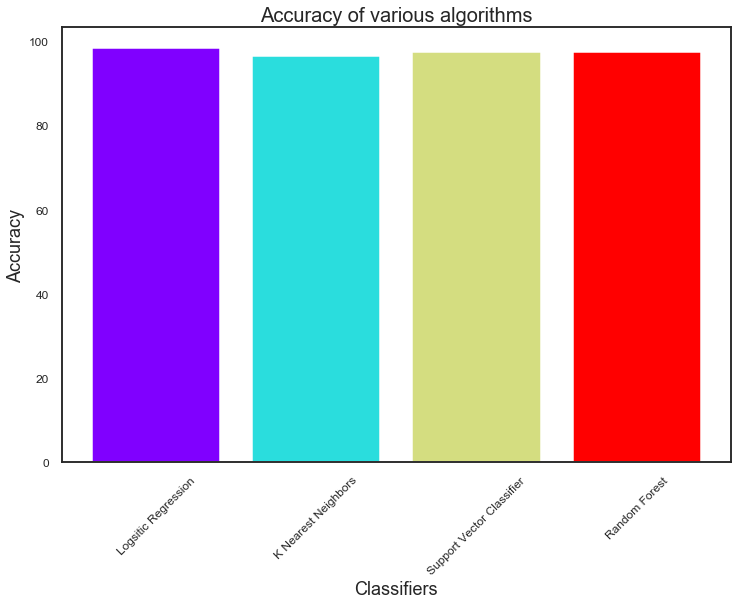

In [36]:
# Performance of different classifiers
import matplotlib.cm as cm
plt.figure(figsize=(12,8))
colors = cm.rainbow(np.linspace(0, 1, 4))
labels = ['Logsitic Regression', 'K Nearest Neighbors', 'Support Vector Classifier', 'Random Forest']
plt.bar(labels,
        accuracy_scores,
        color = colors)
plt.xlabel('Classifiers',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.title('Accuracy of various algorithms',fontsize=20)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)

### Final Classifier Model

We can clearly see that the Logistic Regression model performs the best for the task of Human Activity Recognition with Machine Learning.

### Summary Key Findings and Insights

By inspecting the dataset, we can see that there are a lot of features. 
It is easy to identify that there is an accelerometer, gyroscope, and other values in the data set. 
We can check everyone’s share by plotting a bar graph of each type. Accelerometer values have Acc in them, Gyroscope values have Gyro, and rest can be considered like others:

<BarContainer object of 3 artists>

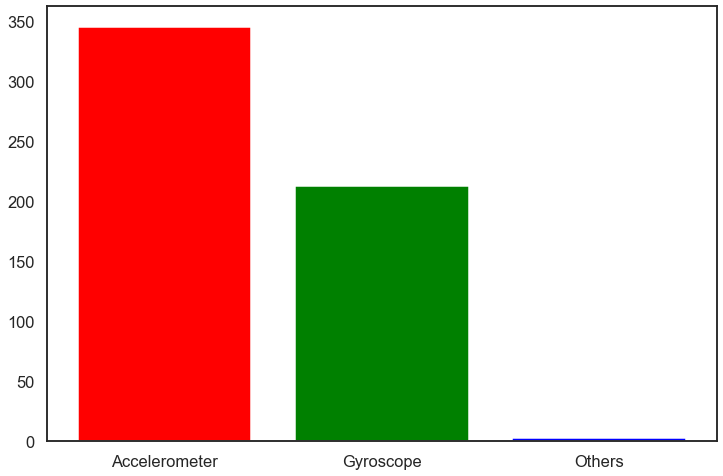

In [40]:
Acc = 0
Gyro = 0
other = 0

for value in X_train.columns:
    if "Acc" in str(value):
        Acc += 1
    elif "Gyro" in str(value):
        Gyro += 1
    else:
        other += 1
        
plt.figure(figsize=(12,8))
plt.bar(['Accelerometer', 'Gyroscope', 'Others'],[Acc,Gyro,other],color=('r','g','b'))

The accelerometer provides the maximum functionality, followed by the gyroscope. The other features are much less so.

### Suggestions for next steps in analyzing this data

- More data can be helpful.
- More data exploration and feature engineering can also be good.
- Using different models like LSTM, neural networks, to see the performance of the data on other models.